In [1]:
from matplotlib import pyplot as plt
from torch import Tensor

from src.common.log import logger
from src.dataset.tno_dataset_collection import TnoDatasetCollection
from src.inverse_problems.compressed_sensing_problem import (
    TotalEmissionsCompressedSensingExperiment,
)
from src.inverse_problems.footprints.footprint_loader import load_gaussian_plume_footprint
from src.inverse_problems.inverse_problems_solver import (
    BasisPursuitSolver,
    GenerativeModelSolver,
    SparsityTransform,
)
from src.models.common.metrics import mse, relative_error, ssim
from src.plotting.city_emission_field_plot import plot_emission_field_tensor

In [2]:
CITY = "Munich"

x = TnoDatasetCollection().get_single_case_study_city_emission_field(city=CITY, year=2018).sum(dim=0)

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'
[INFO] > Test Set has 13 unique cites!                          
	Innsbruck, Großzschocher, Reims, Prague, Dresden, Szczecin, Győr, Hamburg, Gdynia, Magdeburg, Siegen, Duisburg, Aachen
[INFO] > Validation Set has 15 unique cites!
	Nijmegen, Linz, Bydgoszcz, Southampton, Kalisz, Kassel, Wałbrzych, Ingolstadt, Angers, Erfurt, Koblenz, Brussels, Frankfurt am Main, Zielona Góra, Bielefeld
[INFO] > Training Set has 74 unique cites!
	Basel, Leeds, Mannheim, Ulm, Brugge, Ipswich, Berlin, Saint Peters, Odense, Lille, Apeldoorn, Orléans, Antwerpen, Nancy, Liberec, Bremerhaven, Charleroi, Amsterdam, Rotterdam, Brighton, Bremen, Chemnitz, Opole, Le Mans, Gorzów Wielkopolski, Münster, Rostock, Le Havre, Salzbur

In [3]:
sensing_matrix = load_gaussian_plume_footprint(num_stations=30)

snr = 0

problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
    x,
    Tensor(sensing_matrix),
    snr=snr
)

In [15]:
bp_solver = BasisPursuitSolver(verbose=False)
bp_solver_dwt = BasisPursuitSolver(transform=SparsityTransform.DWT, verbose=False)
bp_solver_dct = BasisPursuitSolver(transform=SparsityTransform.DCT, verbose=False)

gen_solver_256 = GenerativeModelSolver.from_vae_model_name("256", plot_loss=True)
gen_solver_512 = GenerativeModelSolver.from_vae_model_name("512", plot_loss=True)
gen_solver_1024 = GenerativeModelSolver.from_vae_model_name("1024", plot_loss=True)
gen_solver_2048 = GenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

gen_solver_256_munich = GenerativeModelSolver.from_vae_model_name("256_munich", plot_loss=True)
gen_solver_512_munich = GenerativeModelSolver.from_vae_model_name("512_munich", plot_loss=True)
gen_solver_1024_munich = GenerativeModelSolver.from_vae_model_name("1024_munich", plot_loss=True)
gen_solver_2048_munich = GenerativeModelSolver.from_vae_model_name("2048_munich", plot_loss=True)

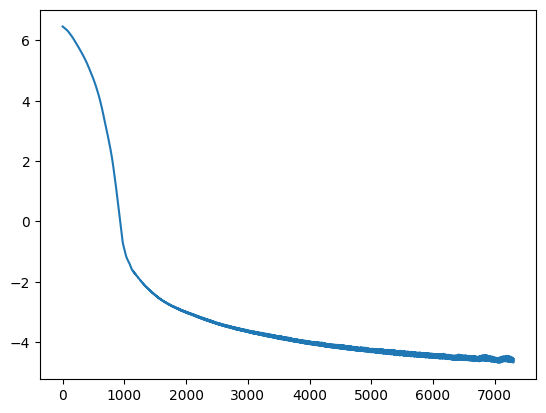

In [8]:
x_rec = problem.solve(gen_solver_256)

In [9]:
logger.info(f"SSIM={ssim(x, x_rec):.3f}")
logger.info(f"Relative Error={100 * relative_error(x, x_rec):.3f}%")

[INFO] > SSIM=0.644
[INFO] > Relative Error=50.113%


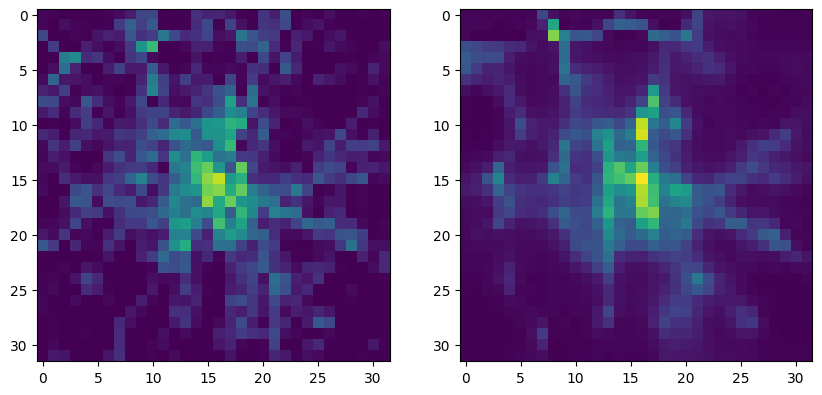

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

vmax = 1.1 * float(x.max())

plot_emission_field_tensor(ax=ax1, emission_field=x, vmax=vmax)
plot_emission_field_tensor(ax=ax2, emission_field=x_rec, vmax=vmax)

In [11]:
snr_db_list = [5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]

[INFO] > SNR 3.1622776601683795 done!
[INFO] > SNR 6.309573444801933 done!
[INFO] > SNR 12.589254117941675 done!
[INFO] > SNR 25.118864315095795 done!
[INFO] > SNR 50.11872336272722 done!
[INFO] > SNR 100.0 done!
[INFO] > SNR 199.52623149688787 done!
[INFO] > SNR 398.1071705534973 done!
[INFO] > SNR 794.3282347242813 done!
[INFO] > SNR 1584.893192461114 done!
[INFO] > SNR 3162.2776601683795 done!
[INFO] > SNR 6309.57344480193 done!


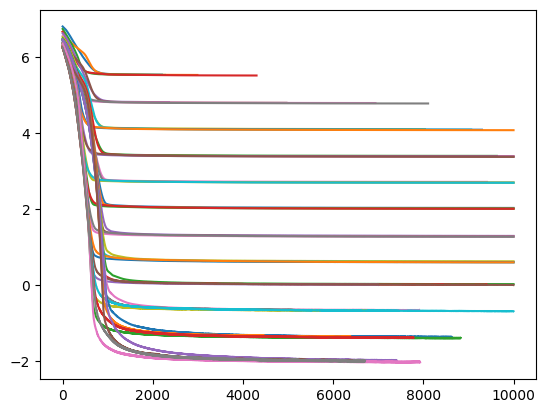

In [12]:
import math

gen_256 = []
gen_512 = []
gen_1024 = []
gen_2048 = []

for snr_db in snr_db_list:
    snr = math.pow(10, snr_db / 10)
    problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
        x,
        Tensor(sensing_matrix),
        snr=snr
    )
    gen_256.append(relative_error(x, problem.solve(gen_solver_256)))
    gen_512.append(relative_error(x, problem.solve(gen_solver_512)))
    gen_1024.append(relative_error(x, problem.solve(gen_solver_1024)))
    gen_2048.append(relative_error(x, problem.solve(gen_solver_2048)))
    logger.info(f"SNR {snr_db} dB done!")

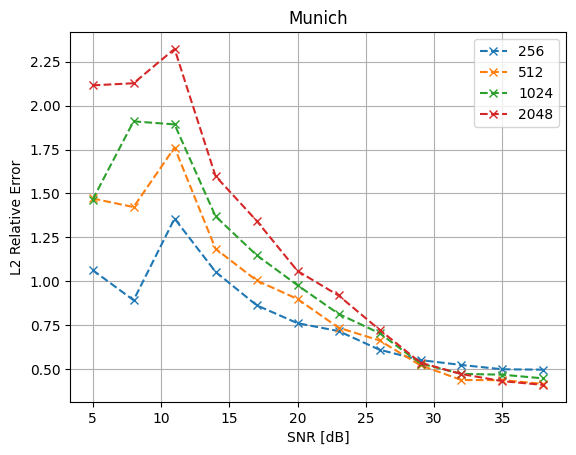

In [14]:
plt.plot(snr_db_list, gen_256, "x--", label="256")
plt.plot(snr_db_list, gen_512, "x--", label="512")
plt.plot(snr_db_list, gen_1024, "x--", label="1024")
plt.plot(snr_db_list, gen_2048, "x--", label="2048")

plt.xlabel("SNR [dB]")
plt.ylabel("L2 Relative Error")

plt.title("Munich")
plt.grid()

plt.legend()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-01
[INFO] > SNR 5 dB done!
[INFO] > SNR 8 dB done!
[INFO] > SNR 11 dB done!
[INFO] > SNR 14 dB done!
[INFO] > SNR 17 dB done!
[INFO] > SNR 20 dB done!
[INFO] > SNR 23 dB done!
[INFO] > SNR 26 dB done!
[INFO] > SNR 29 dB done!
[INFO] > SNR 32 dB done!
[INFO] > SNR 35 dB done!
[INFO] > SNR 38 dB done!


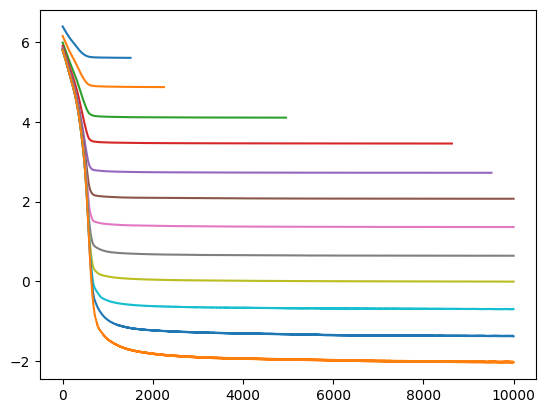

In [16]:
gen_256_munich = []
sparse_reconstruction_dct = []

for snr_db in snr_db_list:
    snr = math.pow(10, snr_db / 10)
    problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
        x,
        Tensor(sensing_matrix),
        snr=snr
    )
    gen_256_munich.append(relative_error(x, problem.solve(gen_solver_256_munich)))
    sparse_reconstruction_dct.append(relative_error(x, problem.solve(bp_solver_dct)))
    logger.info(f"SNR {snr_db} dB done!")

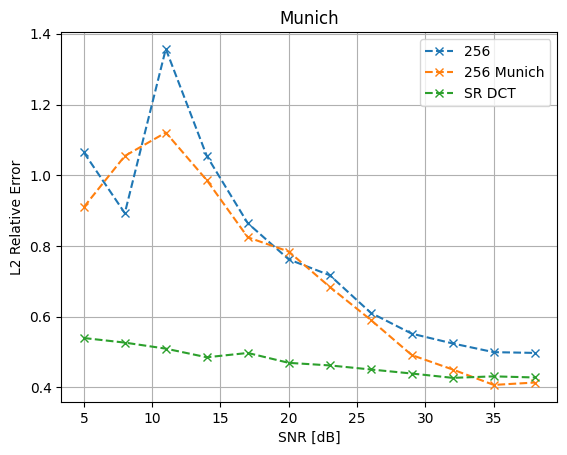

In [17]:
plt.plot(snr_db_list, gen_256, "x--", label="256")
plt.plot(snr_db_list, gen_256_munich, "x--", label="256 Munich")
plt.plot(snr_db_list, sparse_reconstruction_dct, "x--", label="SR DCT")

plt.xlabel("SNR [dB]")
plt.ylabel("L2 Relative Error")

plt.title("Munich")
plt.grid()

plt.legend()